In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

### Tendencia

In [6]:
def dados_tendencia_agricultura(id_municipio=2916500):    
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7", "municipality":"NOME"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["IBGE7", "level_2", "NOME"])[list(range(1985, 2023))].sum().reset_index()
    biomas_agrupados_cidade = biomas_agrupados[(biomas_agrupados["IBGE7"] == id_municipio)&(biomas_agrupados["level_2"] == "Agriculture")]
    serie_agricultura = biomas_agrupados_cidade.melt(id_vars=["IBGE7", "level_2", "NOME"], 
                             var_name="ANO", 
                             value_name="AREA_AGRICULTURA")
    serie_agricultura
    return serie_agricultura

def plot_tendencia(dados_tendencia):
    nome = dados_tendencia["NOME"].values[0]
    dados_tendencia.plot(kind="line", x="ANO", y="AREA_AGRICULTURA", color="g")
    plt.title(f"Dinâmica da área da agricultura em {nome}")
    plt.ylabel("Área de agricultura (Ha)");


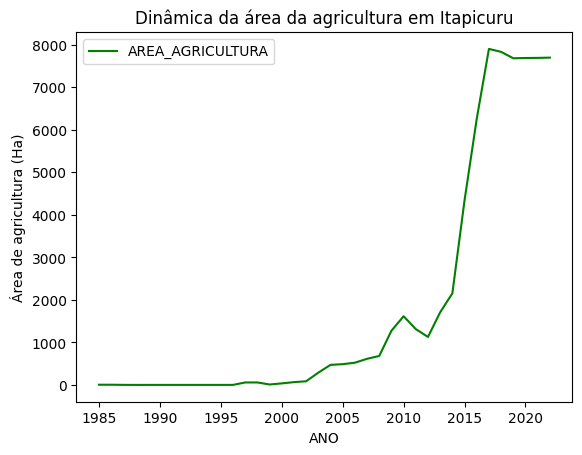

In [7]:
dados_tendencia = dados_tendencia_agricultura()
plot_tendencia(dados_tendencia)

## Séries temporal para previsão de nova área previsão da nova área total destinada a agricultura

In [64]:
def timeseries_to_supervised(df, n_features, n_target):
        n_linhas = 0
        colunas_features = ['var(t - {})'.format(str(i)) for i in range(n_features, -1, -1) if i != 0]
        colunas_target = ['var(t)' if i==0 else 'var(t + {})'.format(str(i)) for i in range(0, n_target)]
        colunas_total = colunas_features + colunas_target
        lista=[]
        
        while n_linhas <= len(df) - n_target - n_features:
            quantidade_de_features_iteracao = df.iloc[n_linhas:n_linhas + n_features].values
            quantidade_de_target_iteracao = df.iloc[n_linhas + n_features: n_linhas + n_features + n_target]
            
            linha = np.concatenate([quantidade_de_features_iteracao, quantidade_de_target_iteracao], axis=0)
            linha_reshape = linha.reshape(1, -1)
            lista.append(linha_reshape[0])
    
            n_linhas += 1
        df_iter = pd.DataFrame(lista, columns=colunas_total)
        return df_iter

def preprocessamento(dados, window):
    X = dados.iloc[:, 0:window]
    y = dados.iloc[:, window:]

    X_train = X[0:round(0.6*len(X))]
    y_train = y[0:round(0.6*len(X))]

    X_test = X[round(0.6*len(X)):]
    y_test = y[round(0.6*len(X)):]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return X_train, X_test, y_train.values, y_test.values, scaler

### 1) Regressão Linear

#### Agricultura

In [4]:
dados_tendencia = dados_tendencia_agricultura()

In [70]:
dados_tendencia.to_csv("..\Dados\Views\serie_temporal_agricultura.csv")

In [65]:
janela = 2
horizon = 5
serie_agricultura_supervised = timeseries_to_supervised(dados_tendencia[["AREA_AGRICULTURA"]], janela, horizon)
X_train, X_test, y_train, y_test, scaler = preprocessamento(serie_agricultura_supervised, janela)

In [62]:
serie_agricultura_supervised

,var(t - 2),var(t - 1),var(t),var(t + 1),var(t + 2),var(t + 3),var(t + 4)
0,4.566366,4.566366,1.053758,0.000000,0.702508,0.702508,0.702508
1,4.566366,1.053758,0.000000,0.702508,0.702508,0.702508,0.702508
2,1.053758,0.000000,0.702508,0.702508,0.702508,0.702508,0.702508
3,0.000000,0.702508,0.702508,0.702508,0.702508,0.702508,0.702508
4,0.702508,0.702508,0.702508,0.702508,0.702508,0.702508,0.702508
5,0.702508,0.702508,0.702508,0.702508,0.702508,0.702508,0.702508
6,0.702508,0.702508,0.702508,0.702508,0.702508,0.702508,58.000435
7,0.702508,0.702508,0.702508,0.702508,0.702508,58.000435,58.000435
8,0.702508,0.702508,0.702508,0.702508,58.000435,58.000435,10.267921
9,0.702508,0.702508,0.702508,58.000435,58.000435,10.267921,35.815060


In [68]:
previsoes = []
for i in range(horizon):
    modelo_linear = LinearRegression()
    modelo_linear.fit(X_train, y_train[:, i])
    y_pred = modelo_linear.predict(X_test)
    mse = mean_squared_error(y_test[:, i], y_pred)
    rmse = np.sqrt(mse)
    print(f"\nMean squared error - {i}: {mse}")
    print(f"Root mean squared error - {i}: {rmse}")

    input = np.array([7688.363295, 7694.679164]).reshape(1, -1)
    input = scaler.transform(input)
    y_previsao = modelo_linear.predict(input)
    print(f"Previsão {2023+i}: {y_previsao[0]}")
    previsoes.append(y_previsao)


Mean squared error - 0: 696778.2292402951
Root mean squared error - 0: 834.7324297284101
Previsão 2023: 6291.727608206955

Mean squared error - 1: 2270675.6353120664
Root mean squared error - 1: 1506.8761181039622
Previsão 2024: 9157.390674827799

Mean squared error - 2: 4790912.736720381
Root mean squared error - 2: 2188.815372917593
Previsão 2025: 10414.866265583927

Mean squared error - 3: 7760518.28819109
Root mean squared error - 3: 2785.770681192386
Previsão 2026: 13002.579313450697

Mean squared error - 4: 41814551.35008885
Root mean squared error - 4: 6466.417195796204
Previsão 2027: 31774.11940510049


## Análise de transição

In [74]:
transicoes_municipais_raw = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                      sheet_name="TRANSICOES_COL8.0")

In [75]:
transicoes_df = transicoes_municipais_raw.copy()
transicoes_df.head()

,feature_id,biome,municipality,state_acronym,geocode,biome [municipality],class_id_to,level_1_id_to,level_2_id_to,level_3_id_to,...,2015-2016,2015-2020,2016-2017,2016-2022,2017-2018,2018-2019,2018-2022,2019-2020,2020-2021,2021-2022
0,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,393108.346771,375299.476204,390452.564163,362080.507020,386982.729188,381548.907517,362424.195116,376968.720871,372147.859587,363759.169172
1,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,1.835615,3.234690,NaN,0.524438,NaN,NaN,NaN,NaN,NaN,NaN
2,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,4.545471,8.474783,4.279844,17.027974,2.178572,0.786912,18.612014,7.940119,3.497145,39.717964
3,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,NaN,1.834875,NaN,6.908685,0.612750,0.610068,6.643013,0.524683,0.524873,5.243668
4,58776,Amazônia,Alta Floresta D'Oeste,RO,1100015,Amazônia [Alta Floresta D'Oeste],3,1,3,3,...,427.453779,1848.489791,396.000144,1692.881132,201.152782,322.922978,1085.080697,218.242734,101.165963,420.252587


In [76]:
transicoes_df.drop(columns=["biome [municipality]", "municipality", "biome", 
                            "feature_id", "state_acronym", "from_color",
                            "to_class", "class_id_to", "to_level_1", "from_level_1",
                            'level_1_id_from', 'level_2_id_from', 'level_3_id_from',
                            'level_1_id_to', 'level_2_id_to',
                            'level_3_id_to', 'level_4_id_to','class_id_from',
                            'to_level_3', 'to_level_4',
                            'to_color', 'level_4_id_from', 
                            'from_level_0', 'from_level_3', 'from_level_4', 
                            'from_class', 'to_level_0'], inplace=True)

transicoes_df.rename(columns={"geocode":"IBGE7"}, inplace=True)
transicao_cidade = transicoes_df[transicoes_df["IBGE7"] == 2916500]

In [77]:
condicao_agricultura = (transicao_cidade["to_level_2"] == "Agriculture")|(transicao_cidade["to_level_2"] == "Mosaic of Agriculture and Pasture")
transicao_cidade_agricultura = transicao_cidade[condicao_agricultura].reset_index(drop=True)
transicao_cidade_agricultura_melted = transicao_cidade_agricultura.melt(id_vars=["IBGE7", 
                                                                          "to_level_2", 
                                                                          "from_level_2"], 
                                                                          value_name="AREA_TRANSICAO",
                                                                          value_vars="1985-2022")

In [78]:
agrupado = transicao_cidade_agricultura_melted.groupby(by="from_level_2")[["AREA_TRANSICAO"]].sum()
agrupado["AREA_TRANSICAO_MEDIA_ANUAL"] = agrupado["AREA_TRANSICAO"] / 38
agrupado

,AREA_TRANSICAO,AREA_TRANSICAO_MEDIA_ANUAL
from_level_2,,
Agriculture,1.492887,0.039286
Forest Formation,967.998018,25.473632
Forest Plantation,0.000000,0.000000
Grassland,64.383974,1.694315
Mosaic of Agriculture and Pasture,6066.919045,159.655764
Other Non Vegetated Area,25.625046,0.674343
Pasture,8370.451930,220.275051
"River, Lake and Ocean",6.228878,0.163918
Savanna Formation,2817.003901,74.131682


In [81]:
cinco_melhores = agrupado.sort_values("AREA_TRANSICAO_MEDIA_ANUAL", ascending=False).iloc[0:4].reset_index()
cinco_melhores

,from_level_2,AREA_TRANSICAO,AREA_TRANSICAO_MEDIA_ANUAL
0,Pasture,8370.451930,220.275051
1,Mosaic of Agriculture and Pasture,6066.919045,159.655764
2,Savanna Formation,2817.003901,74.131682
3,Forest Formation,967.998018,25.473632


In [82]:
cinco_melhores.to_csv(r"..\Dados\Views\dados_transicao.csv", index=False)

## Barplot stacked

In [17]:
def dados_para_stacked_plot():
    biomas_municipais = pd.read_excel(r"..\Dados\MAPBIOMAS\tabela_geral_mapbiomas_col8_biomas_municipios.xlsx", 
                                          sheet_name="COBERTURA_COL8.0")
    biomas_municipais.drop(columns=["biome [municipality]", "municipality", "biome", "feature_id", "class_id"], inplace=True)
    biomas_municipais.rename(columns={"geocode":"IBGE7"}, inplace=True)
    biomas_agrupados = biomas_municipais.groupby(["IBGE7", "level_2"])[list(range(1985, 2023))].sum().reset_index()
    
    biomas_lista = ["Forest Formation", "Mosaic of Agriculture and Pasture", "Pasture", "Savanna Formation"]
    lista_Anos = list(range(2010, 2022))
    biomas_serem_explorados = biomas_agrupados[biomas_agrupados["level_2"].isin(biomas_lista)]
    biomas_serem_explorados = biomas_serem_explorados.melt(id_vars=["IBGE7", "level_2"], var_name="ANO", value_name="AREA_HECTAR")
    biomas_serem_explorados = biomas_serem_explorados[biomas_serem_explorados["ANO"].isin(lista_Anos)]
    return biomas_serem_explorados


def plot_stacked_bar(biomas_serem_explorados):
    pivot_df = biomas_serem_explorados.drop(columns="IBGE7").pivot(index='ANO', columns='level_2', values='AREA_HECTAR')
    pivot_df_percent = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    ax = pivot_df_percent.plot(kind='bar', stacked=True, figsize=(20, 10))
    sns.set_style(None)
    ax.set_xlabel(None)
    plt.ylabel('% de área')
    plt.xticks(rotation=0)
    plt.title('Distribuição das coberturas mais indicadas para transição para Agricultura')
    plt.show()

In [12]:
dados = dados_para_stacked_plot()

In [13]:
dados

,IBGE7,level_2,ANO,AREA_HECTAR
486450,1100015,Forest Formation,2010,398915.111021
486451,1100015,Pasture,2010,192425.327801
486452,1100015,Savanna Formation,2010,17407.160907
486453,1100023,Forest Formation,2010,172582.163853
486454,1100023,Pasture,2010,246937.936589
...,...,...,...,...
719941,5222302,Savanna Formation,2021,48407.961288
719942,5300108,Forest Formation,2021,42655.796914
719943,5300108,Mosaic of Agriculture and Pasture,2021,72048.650065
719944,5300108,Pasture,2021,92266.822726


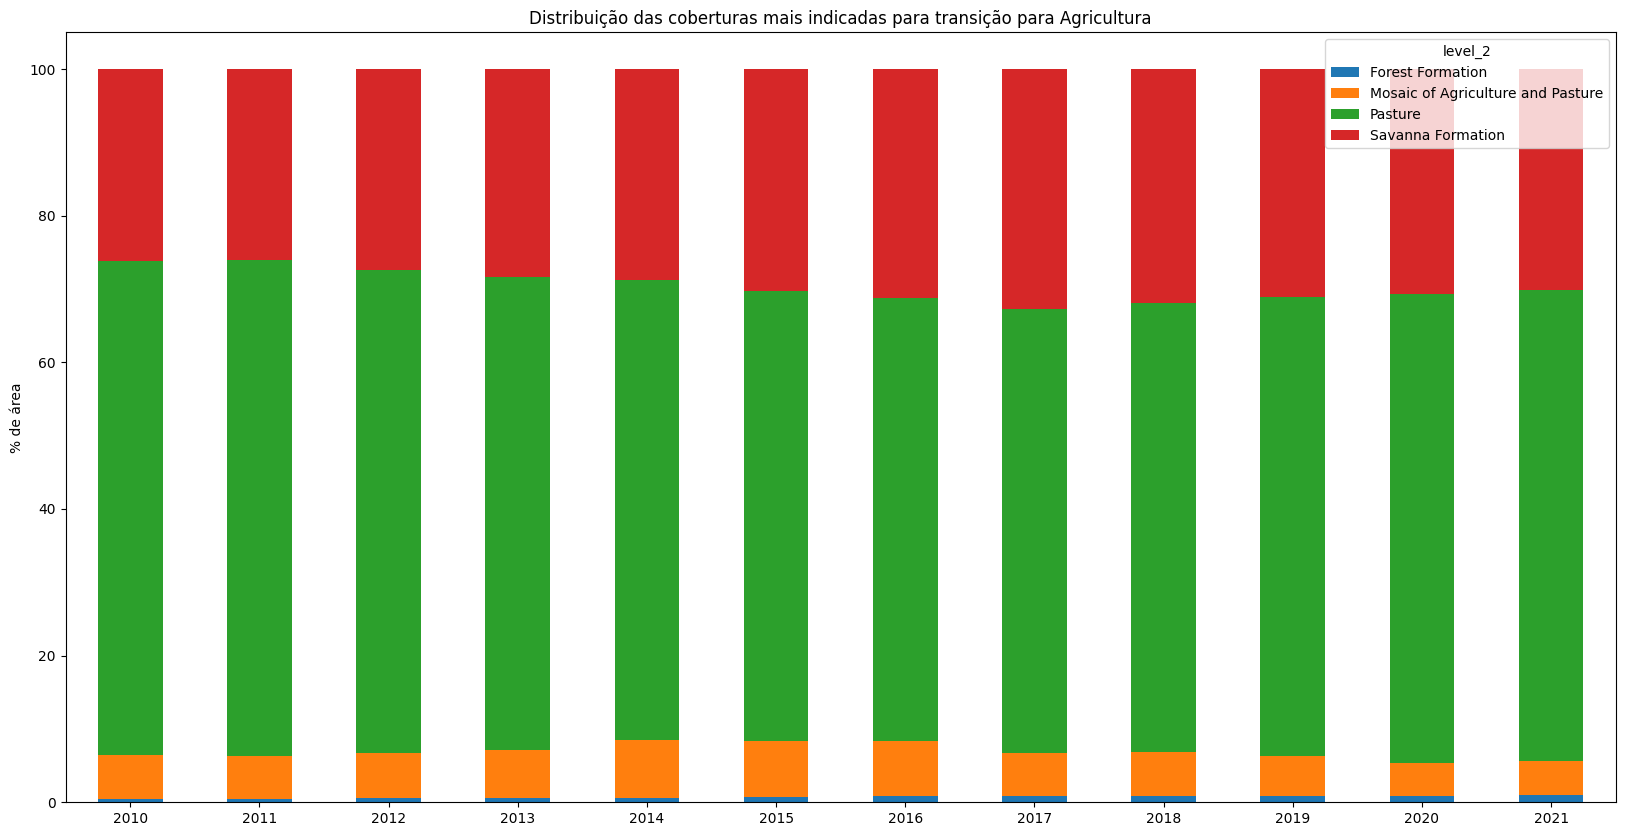

In [18]:
plot_stacked_bar(dados[dados["IBGE7"] == 2916500])